## Experiment 7: Text Analysis
## Nikita Chitre
## Roll No 4
## Batch A

In [ ]:
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, auc, accuracy_score, roc_curve
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Problem 1.1 – Loading the Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/emails.csv')

In [ ]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


### How many emails are in the dataset?

In [ ]:
len(df)

5728

Answer: We can see that length of the dataset is 5728 i.e it has 5728 rows. Since each row represents an email, there are 5728 emails in the dataset. 

### How many of the emails are spam?

In [ ]:
len(df[df['spam'] == 1])

1368

Answer: A one in 'spam' column represents that an email is spam. Hence there are 1368 spam emails in the dataset. 

### Which word appears at the beginning of every email in the dataset? Respond as a lower-case word with punctuation removed.

In [ ]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


By just printing the first five rows of the dataset we can see that the first word is "Subject". However we need to make sure that all the emails have this word as first word. 

In [ ]:
df_clean = df.copy()

In [ ]:
# Converting the words into lower case
df_clean['text'] = df_clean['text'].apply(lambda x: x.lower())

In [ ]:
# removing the punctuations
df_clean['text'] = df_clean['text'].str.replace('[{}]'.format(string.punctuation), '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# splitting the sentence into words and get the first word in all emails
first_word = df_clean['text'].apply(lambda x: x.split(' ')[0])

In [ ]:
first_word

0       subject
1       subject
2       subject
3       subject
4       subject
         ...   
5723    subject
5724    subject
5725    subject
5726    subject
5727    subject
Name: text, Length: 5728, dtype: object

In [ ]:
first_word.value_counts()

subject    5728
Name: text, dtype: int64

Answer: Since the count of word 'subject' is 5728 which is same as the length of the dataset, the word 'subject' appears at the beginning of each email

### Could a spam classifier potentially benefit from including the frequency of the word that appears in every email?

Yes -- the number of times the word appears might help us differentiate spam from ham.

No -- the word appears in every email so this variable would not help us differentiate spam from ham.

In [ ]:
# getting the longest email
max(df_clean['text'], key=len)

'subject from the enron india newsdesk  april 27 th newsclips  fyi news articles from indian press                         forwarded by sandeep kohli  enron  development on  04  27  2001 08  24 am                             nikita varma  04  27  2001 07  51 am  to  nikita varma  enron  development  enron  development  cc   bcc  sandeep kohli  enron  development   subject  from the enron india newsdesk  april 27 th newsclips  friday apr 27 2001  http    www  economictimes  com  today  cmo 3  htm  dpc board empowers md to cancel mseb contract  friday apr 27 2001  http    www  economictimes  com  today  27 compl 1  htm  mseb pays rs 134 cr under  protest  to dpc  friday  april 27  001   enron india md authorised to terminate ppa  friday  april 27  2001  http    www  financialexpress  com  fe 20010427  topl  html  foreign lenders slam brakes on disbursements to dpc  sanjay jog  raghu mohan  global banks comfortable with enron pull  out  friday  april 27  2001  http    www  indian  express

In [ ]:
# finding the length of the longest email 
len(max(df_clean['text'], key=len))

42746

In [ ]:
temp = df_clean.copy()

Printing the count of the word "subject" 

In [ ]:
temp['count_of_subject'] = df_clean['text'].str.count("subject")

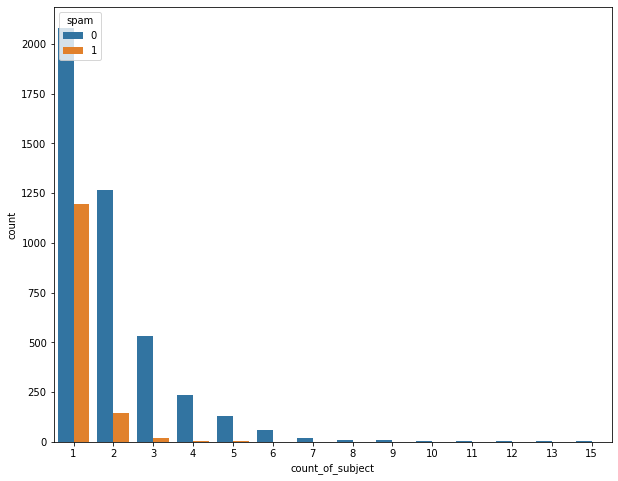

In [ ]:
plt.figure(figsize=(10,8))
_ = sns.countplot(data = temp, x='count_of_subject', hue='spam')

We can see that spam emails have frequency of word "subject" upto 5. Emails which are not spam have high frequency of word "subject".


Answer: Hence spam classifier can potentially benefit from including the frequency of the word that appears in every email

## Problem 2.1 - Preparing the Corpus

In [ ]:
import nltk

In [ ]:
corpus = df.copy()

#### Converting to lower case

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x:x.lower())

In [ ]:
corpus.head()

,text,spam
0,subject: naturally irresistible your corporate...,1
1,subject: the stock trading gunslinger fanny i...,1
2,subject: unbelievable new homes made easy im ...,1
3,subject: 4 color printing special request add...,1
4,"subject: do not have money , get software cds ...",1


#### Removing Punctuations

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x: re.sub(r'[^\w\s]','', x))

#### Tokenize words

In [ ]:
corpus['text'] = corpus['text'].apply(nltk.word_tokenize)

In [ ]:
corpus.head()

,text,spam
0,"[subject, naturally, irresistible, your, corpo...",1
1,"[subject, the, stock, trading, gunslinger, fan...",1
2,"[subject, unbelievable, new, homes, made, easy...",1
3,"[subject, 4, color, printing, special, request...",1
4,"[subject, do, not, have, money, get, software,...",1


We can see that the sentences have been converted into individual words

#### Remove Stop Words
Using the list of stopwords provided in this assignment

In [ ]:
stopwords = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "would", "should", "could", "ought", "i'm", "you're", "he's", "she's", "it's", "we're", "they're", "i've", "you've", "we've", "they've", "i'd", "you'd", "he'd", "she'd", "we'd", "they'd", "i'll", "you'll", "he'll", "she'll", "we'll", "they'll", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", "cannot", "couldn't", "mustn't", "let's", "that's", "who's", "what's", "here's", "there's", "when's", "where's", "why's", "how's", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very"])

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
corpus.head()

,text,spam
0,"[subject, naturally, irresistible, corporate, ...",1
1,"[subject, stock, trading, gunslinger, fanny, m...",1
2,"[subject, unbelievable, new, homes, made, easy...",1
3,"[subject, 4, color, printing, special, request...",1
4,"[subject, money, get, software, cds, software,...",1


#### Stemming 

In [ ]:
ps = PorterStemmer()

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x: [ps.stem(item) for item in x])

In [ ]:
corpus.head()

,text,spam
0,"[subject, natur, irresist, corpor, ident, lt, ...",1
1,"[subject, stock, trade, gunsling, fanni, merri...",1
2,"[subject, unbeliev, new, home, made, easi, im,...",1
3,"[subject, 4, color, print, special, request, a...",1
4,"[subject, money, get, softwar, cd, softwar, co...",1


Here the words have been converted into their root stem

#### Count Vectorizer
Count vectorizer converts the words into document term matrix

In [ ]:
cv = CountVectorizer()

In [ ]:
cor = corpus.copy()

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x: ' '.join(x))

In [ ]:
X = cv.fit_transform(corpus['text'])

### How many terms are in document term matrix?

In [ ]:
X.shape

(5728, 29267)

Answer: By printing the shape of X, we can see that their are 29267 terms in the document term matrix.

### Limiting dtm to contain terms appearing in at least 5% of documents 

In [ ]:
cv_sdtm = CountVectorizer(max_df = 0.05)

In [ ]:
X_sdtm = cv_sdtm.fit_transform(corpus['text'])

In [ ]:
X_sdtm.shape

(5728, 28895)

Answer: We can see that the new sdtm matrix has 28895 terms.

## Problem 3.1 – Building machine learning models

#### Splitting the data into train and test with proportion 70-30

In [ ]:
X_train_cv, X_test_cv, y_train, y_test = train_test_split(X_sdtm, corpus['spam'], test_size=0.3, random_state=44)

In [ ]:
X_train_cv.shape

(4009, 28895)

In [ ]:
X_test_cv.shape

(1719, 28895)

We can see that the dataset is split into 70-30 proportion

### Cart Model

#### Training CART Model

In [ ]:
cart = DecisionTreeClassifier(criterion='gini')

In [ ]:
cart.fit(X_train_cv, y_train)

DecisionTreeClassifier()

### Random Forest Classifier

#### Training Random Forest Model

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train_cv, y_train)

RandomForestClassifier()

### What is the training set accuracy of spamCART?

In [ ]:
y_train_pred_cart = cart.predict(X_train_cv.toarray())

In [ ]:
print(f'Accuracy on training dataset: {accuracy_score(y_train, y_train_pred_cart)}')

Accuracy on training dataset: 1.0


Answer: The accuracy on training dataset is 100%

### What is the training set accuracy of spamRF?

In [ ]:
y_train_pred_rf = rf.predict(X_train_cv.toarray())

In [ ]:
print(f'Accuracy on training dataset: {accuracy_score(y_train, y_train_pred_rf)}')

Accuracy on training dataset: 1.0


Answer: The accuracy on training dataset is 100%

### What is the training set AUC of spamCART?

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_cart)
print(f'AUC on training dataset: {auc(fpr, tpr)}')

AUC on training dataset: 1.0


Answer: The AUC on training dataset is 1.0.

### What is the training set AUC of spamRF?

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_rf)
print(f'AUC on training dataset: {auc(fpr, tpr)}')

AUC on training dataset: 1.0


Answer: The AUC on training dataset is 1.0.

## Problem 4.1 – Evaluating on the Test Set 

### What is the testing set accuracy of spamCART?

In [ ]:
y_test_pred_cart = cart.predict(X_test_cv.toarray())

In [ ]:
print(f'Accuracy on test dataset: {(accuracy_score(y_test, y_test_pred_cart) * 100):.1f} %')

Accuracy on test dataset: 92.6 %


Answer: The accuracy on testing dataset is 92.6%

### What is the testing set accuracy of spamRF?

In [ ]:
y_test_pred_rf = rf.predict(X_test_cv.toarray())

In [ ]:
print(f'Accuracy on test dataset: {(accuracy_score(y_test, y_test_pred_rf) * 100):.1f} %')

Accuracy on test dataset: 95.8 %


Answer: The accuracy on testing dataset is 95.8%

### What is the testing set AUC of spamCART?

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_cart)
print(f'AUC on testing dataset: {auc(fpr, tpr):.2f}')

AUC on testing dataset: 0.89


Answer: The AUC on testing dataset is 0.89.

### What is the testing set AUC of spamRF?

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_rf)
print(f'AUC on testing dataset: {auc(fpr, tpr):.2f}')

AUC on testing dataset: 0.92


Answer: The AUC on testing dataset is 0.92.

### Which model had the best testing set performance, in terms of accuracy and AUC?

#### Plotting ROC Curve for both the models

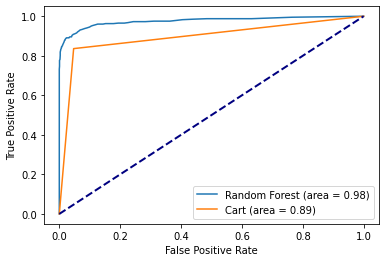

In [ ]:
y_pred_proba_rf = rf.predict_proba(X_test_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

#create ROC curve
plt.plot(fpr,tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

y_pred_proba_cart = cart.predict_proba(X_test_cv)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_cart)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr, label='Cart (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],color="navy",lw=2,linestyle="--")


plt.legend()
plt.show()

Since Random Forest has a larger ROC Area that CART model, Random forest is better than CART in terms of AUC

#### Comparing Accuracy of the two Models

In [ ]:
pd.DataFrame([['CART', round((accuracy_score(y_test, y_test_pred_cart) * 100),1)],
              ['Random Forest', round((accuracy_score(y_test, y_test_pred_rf) * 100),1)]],
             columns=['Model','Testing Accuracy'])

,Model,Testing Accuracy
0,CART,92.6
1,Random Forest,95.8


We can see that Random Fores has higher accuracy than CART model.

Answer: Therefore, Random Forest model has better testing performance than CART model in terms of AUC and Accuracy.

### Why is random forest performing better?

*   Random Forest creates multiple CART trees based on "bootstrapped" samples of data and then combines the predictions.
*   Usually, the combination is an average of all the predictions from all CART models. 
*   Random Forest has better predictive power and accuracy than a single CART model (because of random forest exhibit lower variance).




## Conclusion

*   It is important to remove the stopwords from the textual data since they can negatively affect the model performance. 
*   Stemming helps us obtain the root form of a derived word.
*   Since the document term matrix might be very sparse, we can limit the dtm to contain words appearing in at least a certain number of documents. This can reduce the number of terms in our matrix and decrease the training time.



